In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))
    
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:2] 
n_proc = 8
rank = 0


In [4]:
%%px

cacheEnstrophyData = False
loadEnstrophyFromCache = True

folder = "/home/idies/workspace/scratch"
filename = "ref-enstrophy-"+str(rank)+".npz"

file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    w2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    w2[:,:,:] = content['w2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,w2=w2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] 
Finished loading
Load from disk: 4.23 seconds


In [5]:
%%px

avgOmega = np.average(w2)
avgOmegaGl=np.zeros(1,dtype='float32')

comm.Reduce([avgOmega,MPI.REAL],[avgOmegaGl,MPI.REAL],op=MPI.SUM)
avgOmega = avgOmegaGl[0]/nproc
avgOmega = comm.bcast(avgOmega, root=0)

##########################

minw2 = w2.min()
maxw2 = w2.max()

minwGl=np.zeros(nproc,dtype='float32')
maxwGl=np.zeros(nproc,dtype='float32')

comm.Allgather([minw2,MPI.REAL],[minwGl,MPI.REAL])
comm.Allgather([maxw2,MPI.REAL],[maxwGl,MPI.REAL])

minw2 = minwGl.min()
maxw2 = maxwGl.max()

comm.Barrier()

if rank==0:
    print("0.5<w^2> : "+str(avgOmega/2))
    print("min w2/<w^2> : "+str(minw2/avgOmega))
    print("min w2/<w^2> : "+str(maxw2/avgOmega))

[stdout:2] 
0.5<w^2> : 249.21774292
min w2/<w^2> : 1.43020472082e-07
min w2/<w^2> : 675.170126447


In [6]:
%%px

dx = isotropic1024coarse['dx']
ner = int(1024*np.sqrt(3))
rbins = np.linspace(-0.5*dx,2*np.pi*np.sqrt(3)+0.5*dx,ner+1)

comm.Barrier(); t1=MPI.Wtime()

chi = ft.zeros_aligned((nx,ny,nz), dtype='float32')

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocating vectors: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Alocating vectors: 1.22 seconds


In [7]:
%%px

t=5

chi[w2 > t*avgOmega] = 1

In [8]:
%%px

L = 128

Chkx = nx//L
Chky = ny//L
Chkz = nz//L

boxnum = 0

for i in range(Chkx):
    for j in range(Chky):
        for k in range(Chkz):
            shr = np.average(chi[i*L:(i+1)*L,j*L:(j+1)*L,k*L:(k+1)*L])
            boxnum += math.ceil(shr)

lboxnum=np.zeros(1,dtype='float32')
gboxnum=np.zeros(1,dtype='float32')
lboxnum[0] = float(boxnum)

comm.Allreduce([lboxnum,MPI.REAL],[gboxnum,MPI.REAL],op=MPI.SUM)

if rank==0:
    print(int(gboxnum))

[stdout:2] 512


In [29]:
%%px

res = []
#for t in [1]:#,2,3,4,5,6]:
for t in [1,2,3,4,5,6]:
    #t=5
    chi[:,:,:] = 0.
    chi[w2 > t*avgOmega] = 1
    
    dims = []
    
    # Everything but the smallest 
    for L in [128,64,32,16,8,4,2]:
        Chkx = nx//L
        Chky = ny//L
        Chkz = nz//L
        
        boxnum = 0
        
        for i in range(Chkx):
            for j in range(Chky):
                for k in range(Chkz):
                    shr = np.average(chi[i*L:(i+1)*L,j*L:(j+1)*L,k*L:(k+1)*L])
                    boxnum += math.ceil(shr)
                    
        lboxnum=np.zeros(1,dtype='float32')
        gboxnum=np.zeros(1,dtype='float32')
        lboxnum[0] = float(boxnum)
        
        comm.Allreduce([lboxnum,MPI.REAL],[gboxnum,MPI.REAL],op=MPI.SUM)
        
        dims.append(gboxnum)
        
    # The smallest
    boxnum = np.sum(chi)
    lboxnum=np.zeros(1,dtype='float32')
    gboxnum=np.zeros(1,dtype='float32')
    lboxnum[0] = float(boxnum)
    
    comm.Allreduce([lboxnum,MPI.REAL],[gboxnum,MPI.REAL],op=MPI.SUM)
    
    dims.append(gboxnum)
    dims = np.array(dims,dtype='int64')
    dims = dims.flatten()
    tmpdims = np.zeros(dims.shape[0],dtype='int64')
    tmpdims[:] = dims[:]
    print(dims)
    
    res.append(dims)

[stdout:0] 
[      512      4096     32762    258344   1837853  10670385  53255392
 256066752]
[      512      4096     32664    245140   1492981   7093167  29954718
 127967776]
[     512     4096    32379   227901  1220762  5101770 19534000 77747880]
[     512     4095    31935   210130  1013850  3863446 13811795 52237716]
[     512     4093    31360   193017   853923  3032679 10284426 37383008]
[     512     4091    30673   177036   728804  2445219  7945649 27947200]
[stdout:1] 
[      512      4096     32762    258344   1837853  10670385  53255392
 256066752]
[      512      4096     32664    245140   1492981   7093167  29954718
 127967776]
[     512     4096    32379   227901  1220762  5101770 19534000 77747880]
[     512     4095    31935   210130  1013850  3863446 13811795 52237716]
[     512     4093    31360   193017   853923  3032679 10284426 37383008]
[     512     4091    30673   177036   728804  2445219  7945649 27947200]
[stdout:2] 
[      512      4096     32762    258344

[stdout:2] [ -2.4762856   19.47700016]


[output:2]

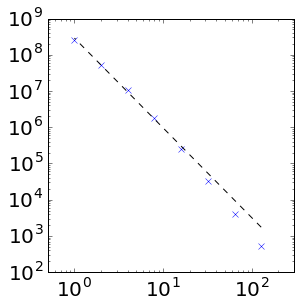

In [24]:
%%px
%matplotlib inline

rm1 = np.array([128,64,32,16,8,4,2,1])
    
if rank==0:
    plt.figure(figsize=(15,10))
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    
    for i in range(1):#6):
        box = np.array(res[i],dtype='int64')
        
        logrm1 = np.log(rm1)
        logbox = np.log(box)
        
        ax = plt.subplot(2,3,i+1)
        plt.xlim([0.5,3*10**(2)])
    
        fit = np.polyfit(logrm1[rm1<1/0.04],logbox[rm1<1/0.04],1)
        print(fit)
    
        plt.loglog(rm1,box,'x')
        plt.loglog(rm1,np.exp(fit[1])*(rm1**(fit[0])),'k--')

Here are the first set of results for box counting dimention. The thresholds range from $1$ to $6$ times the average enstrophy. The dimensions can be seen below, and are clearly smaller than the correlation dimension seen in the 2-point correlation function. 

[stdout:2] 
[ -2.4762856   19.47700016]
[ -2.23824334  18.75946393]
[ -2.08286381  18.23814224]
[ -1.96833164  17.82152028]
[ -1.87852333  17.47137728]
[ -1.80515966  17.16785793]


[output:2]

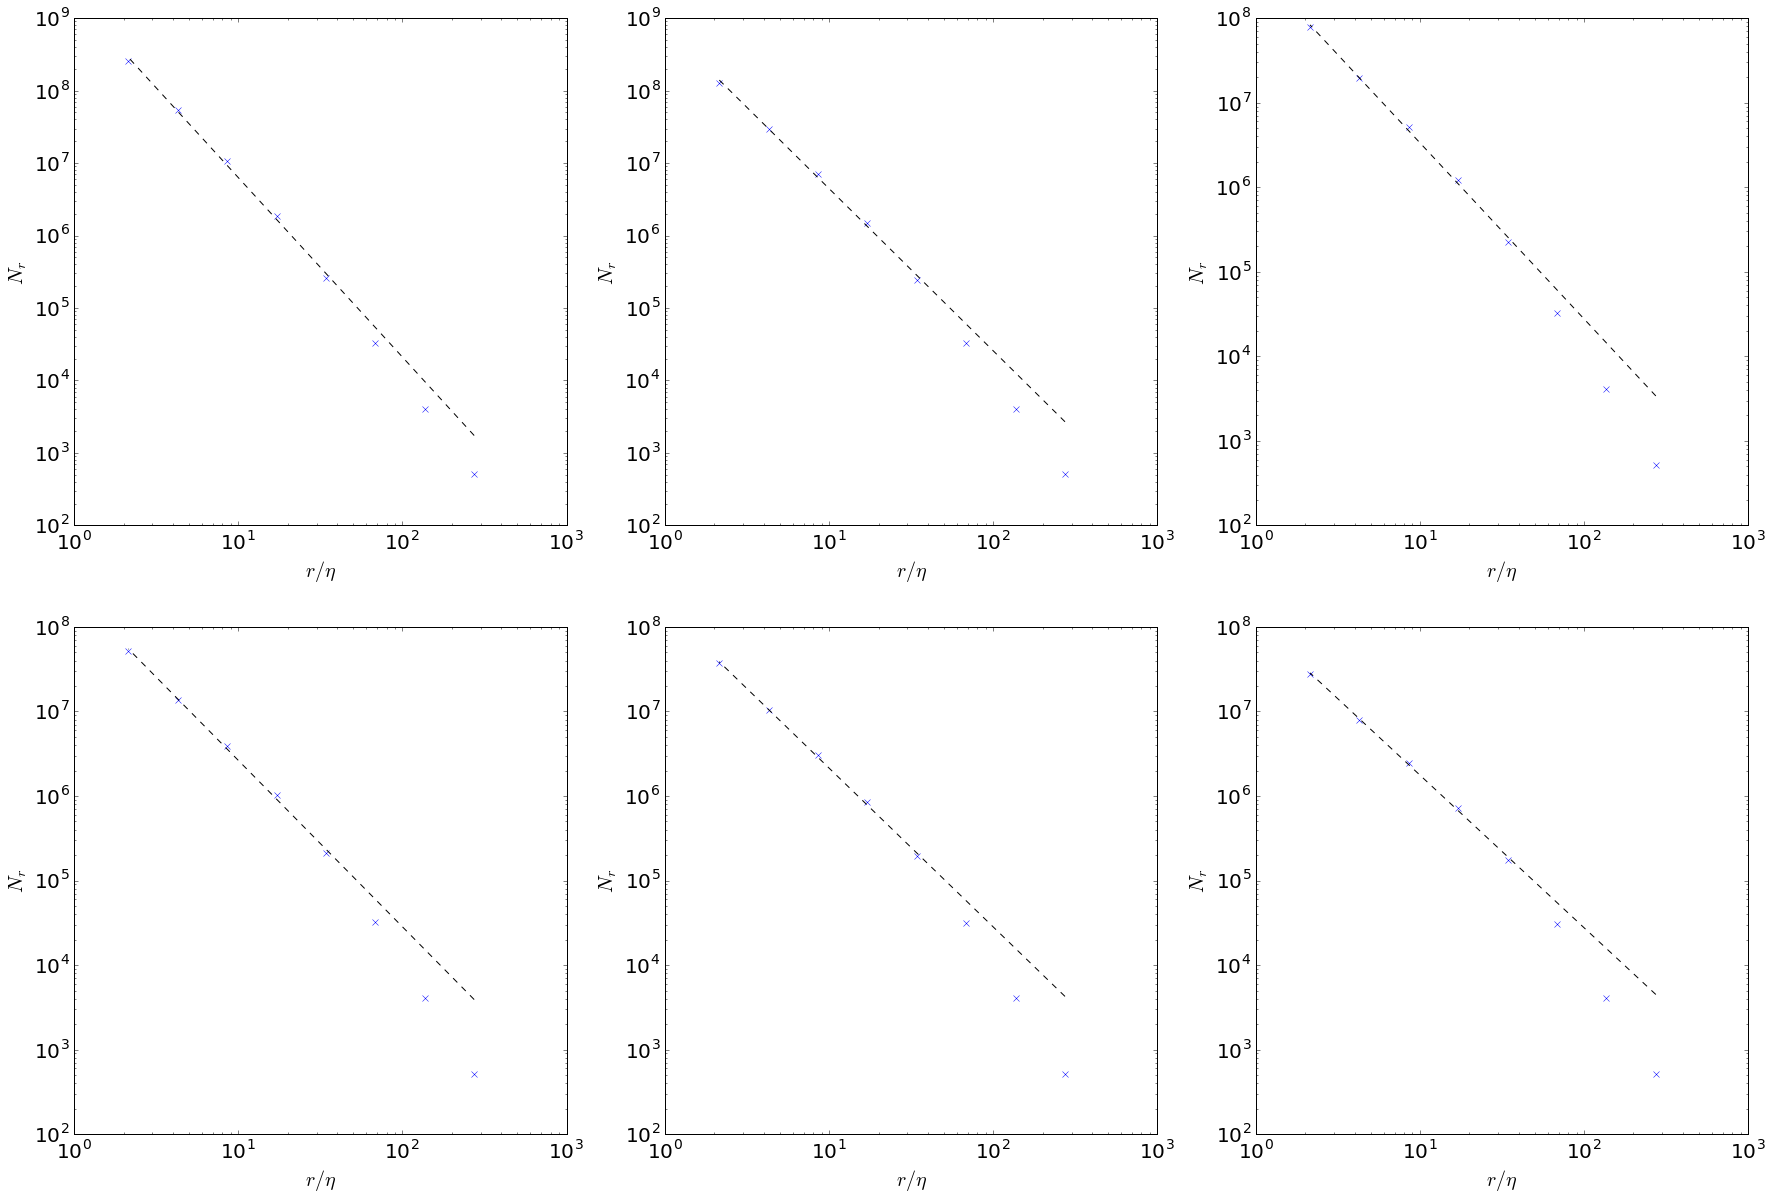

In [42]:
%%px
%matplotlib inline

rm1 = np.array([128,64,32,16,8,4,2,1])
eta = 0.00287
    
if rank==0:
    plt.figure(figsize=(30,20))
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    
    for i in range(6):
        box = np.array(res[i],dtype='int64')
        
        logrm1 = np.log(rm1)
        logbox = np.log(box)
        
        ax = plt.subplot(2,3,i+1)
        plt.xlabel(r'$r/\eta$',size=20)
        plt.ylabel(r'$N_r$',size=20)
        #plt.xlim([0.5,3*10**(2)])
    
        fit = np.polyfit(logrm1[rm1<1/0.04],logbox[rm1<1/0.04],1)
        print(fit)
    
        plt.loglog(rm1*dx/eta,box,'x')
        plt.loglog(rm1*dx/eta,np.exp(fit[1])*(rm1**(fit[0])),'k--')

In [43]:
%%px

res = []
#for t in [1]:#,2,3,4,5,6]:
for t in [7,10,15,20,30,50]:
    #t=5
    chi[:,:,:] = 0.
    chi[w2 > t*avgOmega] = 1
    
    dims = []
    
    # Everything but the smallest 
    for L in [128,64,32,16,8,4,2]:
        Chkx = nx//L
        Chky = ny//L
        Chkz = nz//L
        
        boxnum = 0
        
        for i in range(Chkx):
            for j in range(Chky):
                for k in range(Chkz):
                    shr = np.average(chi[i*L:(i+1)*L,j*L:(j+1)*L,k*L:(k+1)*L])
                    boxnum += math.ceil(shr)
                    
        lboxnum=np.zeros(1,dtype='float32')
        gboxnum=np.zeros(1,dtype='float32')
        lboxnum[0] = float(boxnum)
        
        comm.Allreduce([lboxnum,MPI.REAL],[gboxnum,MPI.REAL],op=MPI.SUM)
        
        dims.append(gboxnum)
        
    # The smallest
    boxnum = np.sum(chi)
    lboxnum=np.zeros(1,dtype='float32')
    gboxnum=np.zeros(1,dtype='float32')
    lboxnum[0] = float(boxnum)
    
    comm.Allreduce([lboxnum,MPI.REAL],[gboxnum,MPI.REAL],op=MPI.SUM)
    
    dims.append(gboxnum)
    dims = np.array(dims,dtype='int64')
    dims = dims.flatten()
    tmpdims = np.zeros(dims.shape[0],dtype='int64')
    tmpdims[:] = dims[:]
    print(dims)
    
    res.append(dims)

[stdout:0] 
[     512     4087    29889   162343   628511  2012238  6312758 21583506]
[     512     4041    27159   126003   424356  1223382  3543102 11340123]
[    512    3927   22576   86218  249439  642877 1701770 5041066]
[    512    3724   18579   61727  160959  385608  960654 2687892]
[    508    3196   12617   34876   79775  173359  396708 1020547]
[   487   2237   6477  14388  28182  54468 112064 257883]
[stdout:1] 
[     512     4087    29889   162343   628511  2012238  6312758 21583506]
[     512     4041    27159   126003   424356  1223382  3543102 11340123]
[    512    3927   22576   86218  249439  642877 1701770 5041066]
[    512    3724   18579   61727  160959  385608  960654 2687892]
[    508    3196   12617   34876   79775  173359  396708 1020547]
[   487   2237   6477  14388  28182  54468 112064 257883]
[stdout:2] 
[     512     4087    29889   162343   628511  2012238  6312758 21583506]
[     512     4041    27159   126003   424356  1223382  3543102 11340123]
[    512

Again, here are the results for box counting dimention. The thresholds range from $7$ to $50$ times the average enstrophy. The dimensions can be seen below, and are clearly smaller than the correlation dimension seen in the 2-point correlation function. 

[stdout:2] 
[ -1.7437741   16.89915556]
[ -1.60453348  16.23313363]
[ -1.4509469   15.40056354]
[ -1.3466183   14.75912849]
[ -1.20559973  13.77860503]
[ -1.03190344  12.3931307 ]


[output:2]

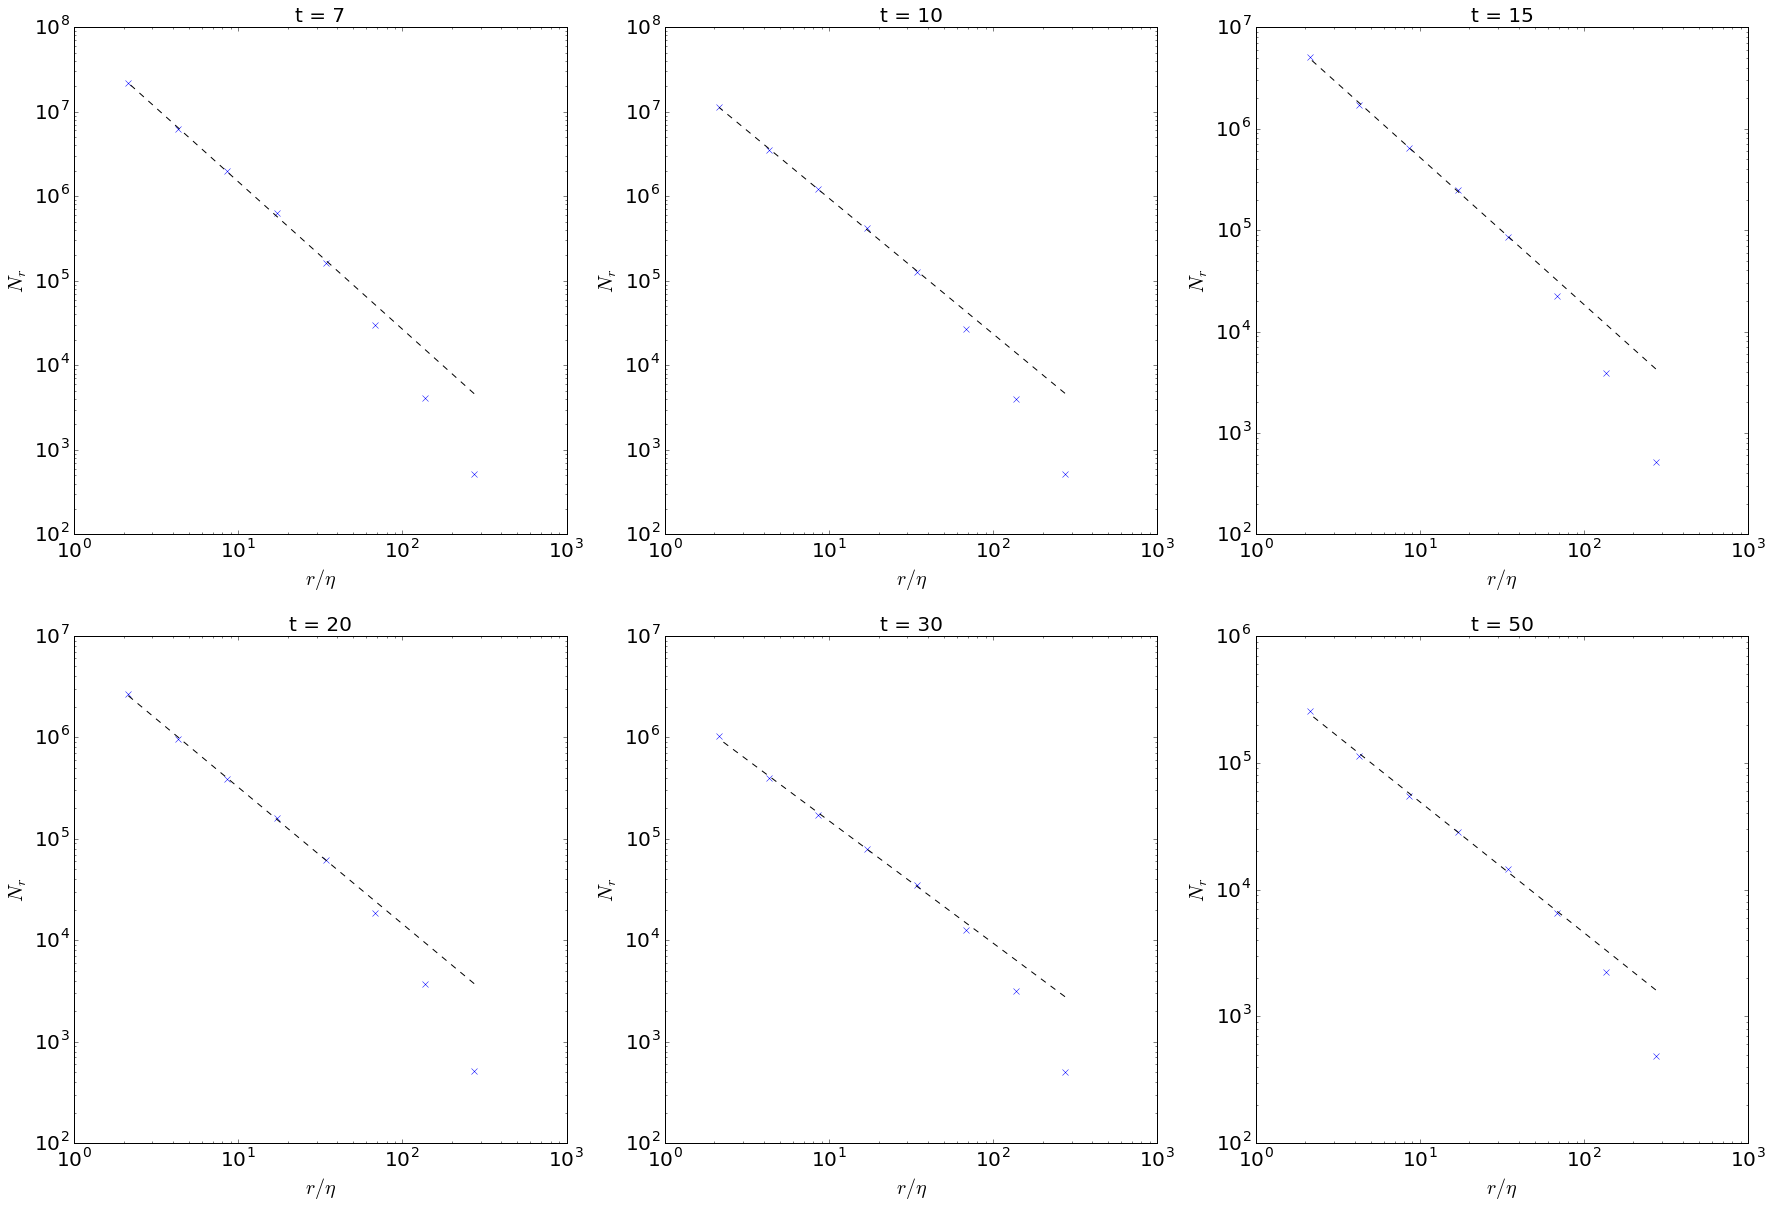

In [47]:
%%px
%matplotlib inline

rm1 = np.array([128,64,32,16,8,4,2,1])
eta = 0.00287
t = [7,10,15,20,30,50]
    
if rank==0:
    plt.figure(figsize=(30,20))
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    
    for i in range(6):
        box = np.array(res[i],dtype='int64')
        
        logrm1 = np.log(rm1)
        logbox = np.log(box)
        
        ax = plt.subplot(2,3,i+1)
        plt.title("t = "+str(t[i]),size=20)
        plt.xlabel(r'$r/\eta$',size=20)
        plt.ylabel(r'$N_r$',size=20)
        #plt.xlim([0.5,3*10**(2)])
    
        fit = np.polyfit(logrm1[rm1<1/0.04],logbox[rm1<1/0.04],1)
        print(fit)
    
        plt.loglog(rm1*dx/eta,box,'x')
        plt.loglog(rm1*dx/eta,np.exp(fit[1])*(rm1**(fit[0])),'k--')

In [49]:
%%px

t = [1,2,3,4,5,6,7,10,15,20,30,50]

corrdim = [3-0.109211,3-0.18944021,3-0.25261053,3-0.30578336,3-0.35221312,3-0.39372815,3-0.43127753,3-0.52659145,3-0.65055973,3-0.74922884,3-0.90409954,3-1.13918621]
boxdim = [2.4762856,2.23824334,2.08286381,1.96833164,1.87852333,1.80515966,1.7437741,1.60453348,1.4509469,1.3466183,1.20559973,1.03190344]

A more direct comparison can be seen in the pictures below. There we compare the dimensions calculated via the two-point correlation functions of excursion sets, and the box counting dimensions, both as functions of the threshold. First we use a linear plot, and then a semilog plot. 

[output:2]

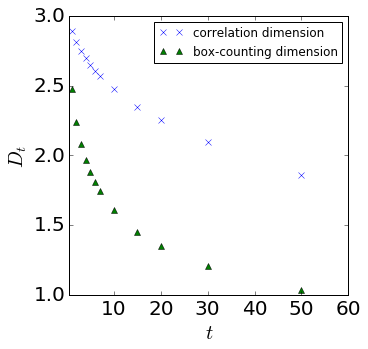

In [85]:
%%px 

if rank == 0:
    plt.figure(figsize=(5,5))
    plt.xlim(0.5,60)    
    plt.xlabel(r'$t$',size=20)    
    plt.ylabel(r'$D_t$',size=20)
    plt.plot(t,corrdim,'x',label='correlation dimension')
    plt.plot(t,boxdim,'^',label='box-counting dimension')
    plt.legend(loc='upper right')

[output:2]

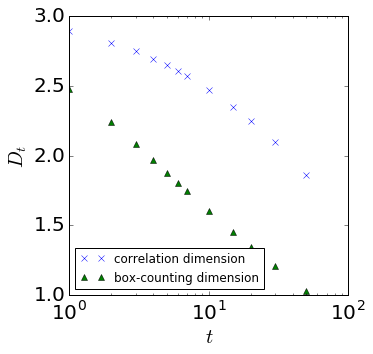

In [86]:
%%px

if rank == 0:
    plt.figure(figsize=(5,5))
    plt.xlabel(r'$t$',size=20)    
    plt.ylabel(r'$D_t$',size=20)
    plt.semilogx(t,corrdim,'x',label='correlation dimension')
    plt.semilogx(t,boxdim,'^',label='box-counting dimension')
    plt.legend(loc='lower left')

Just as an comparison of how much the box counting and correlation dimensions differ, we plot one against the other. The traced line is the line of $D_{box}=D_{corr}$.

[output:2]

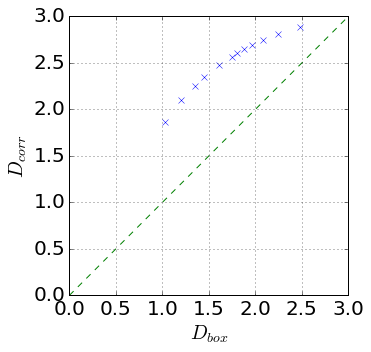

In [87]:
%%px

if rank == 0:
    plt.figure(figsize=(5,5))
    plt.xlim(0.0,3.0)
    plt.ylim(0.0,3.0)
    x = np.linspace(0,3.,100)
    plt.xlabel(r'$D_{box}$',size=20)    
    plt.ylabel(r'$D_{corr}$',size=20)
    plt.plot(boxdim,corrdim,'x')
    plt.plot(x,x,'--')
    plt.grid()